In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
import sys

sys.path.insert(0, '../')
from utils.color_embedding import TFColorEmbedding
from utils.array_utils import get_median_intensive_value
from utils.visualization import draw_colors_horizontal_circles, add_color_bar_to_image
from utils.topological_colors_extraction import colors_grouping, get_class_index_from_groups

sys.path.insert(0, '../third_party/umato/')
import umato

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

figure_size = (10, 8)

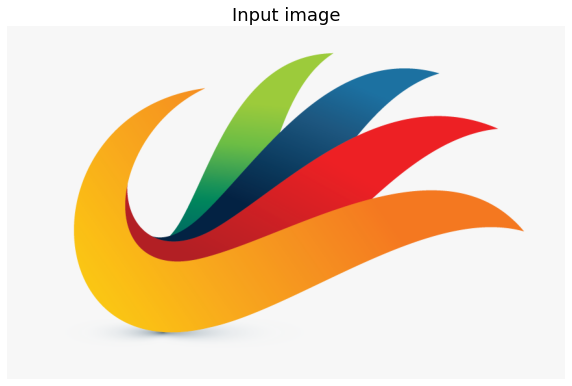

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ../third_party/palette_embedding/python/../model/variables/variables


In [46]:
# Loading input image

image_path = '../examples/logo_3.png'
img = cv2.imread(image_path, cv2.IMREAD_COLOR)

if img is None:
    print('Can\'t load image: {}'.format(image_path))
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Input image', fontsize=18)
plt.imshow(img)
plt.show()

resized = img.copy()
if max(resized.shape) > 50:
    resized_k = 50 / max(resized.shape)
    resized = cv2.resize(
        resized,
        None,
        fx=resized_k,
        fy=resized_k,
        interpolation=cv2.INTER_CUBIC
    )
    
color_embdding_model = TFColorEmbedding()

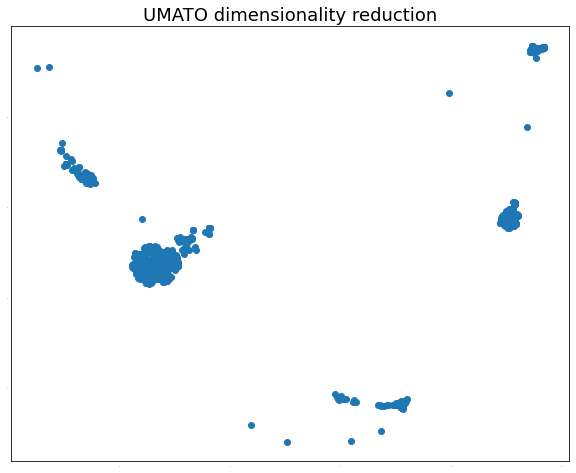

In [47]:
# Colors embeddings prediction
pixels = np.array([color_embdding_model(cl) for cl in resized.reshape((-1, 3))])

# UMATO dimensionality reduction
comp_pixels = umato.UMATO(
    n_neighbors=250,
    global_n_epochs=50,
    local_n_epochs=50,
    hub_num=300,
    verbose=False,
    init='spectral',
    random_state=42
).fit_transform(pixels)

plt.figure(figsize=figure_size)
plt.title('UMATO dimensionality reduction', fontsize=18)
plt.scatter(comp_pixels[:, 0], comp_pixels[:, 1])
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.show()

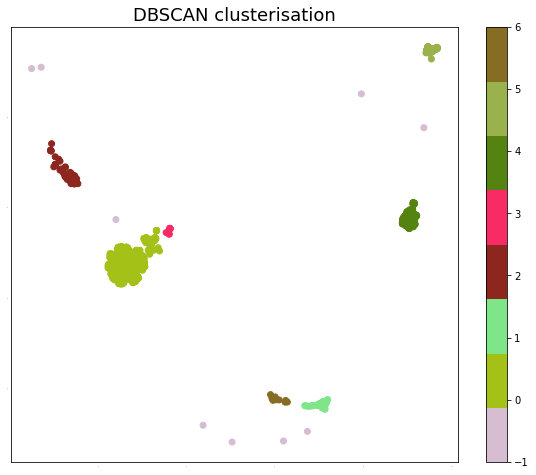

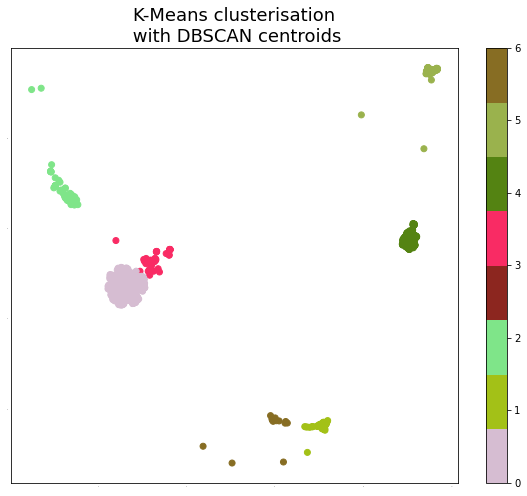

In [49]:
# First step of clusterisation
clustering = DBSCAN(
    eps=0.2,
    min_samples=4,
    n_jobs=12
).fit(comp_pixels)

colors = np.random.randint(0, 255, size=(len(set(clustering.labels_)), 3), dtype=np.uint8)
full_cmp = ListedColormap(colors / 255.0)

clusters_centroids = np.array([
    comp_pixels[clustering.labels_ == i].mean(axis=0)
    for i in set(clustering.labels_)
    if i != -1
])

plt.figure(figsize=figure_size)
plt.title('DBSCAN clusterisation', fontsize=18)
plt.scatter(
    comp_pixels[:, 0], comp_pixels[:, 1], 
    c=clustering.labels_,
    cmap=full_cmp
)
plt.colorbar()
plt.tick_params(axis='both', labelsize=0, length = 0)

# Second step of clusterisation
k_means_clustering = KMeans(
    n_clusters=len([cl for cl in set(clustering.labels_) if cl != -1]),
    n_init=1,
    n_jobs=4,
    init=clusters_centroids,
    random_state=42
).fit(comp_pixels)


plt.figure(figsize=figure_size)
plt.title('K-Means clusterisation\n with DBSCAN centroids', fontsize=18)
plt.scatter(
    comp_pixels[:, 0], comp_pixels[:, 1], 
    c=k_means_clustering.labels_,
    cmap=np.roll(full_cmp, 2).tolist()
)
plt.colorbar()
plt.tick_params(axis='both', labelsize=0, length = 0)

plt.show()

clustering = k_means_clustering

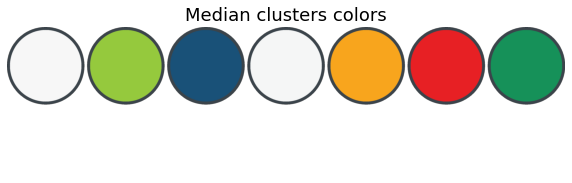

In [50]:
cluster_values = [
    resized.reshape((-1, 3))[clustering.labels_ == i]
    for i in set(clustering.labels_)
]

cluster_values = [
    get_median_intensive_value(np.array(cluster_values[i]))
    for i in range(len(cluster_values))
]

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Median clusters colors', fontsize=18)
plt.imshow(draw_colors_horizontal_circles(cluster_values))
plt.show()

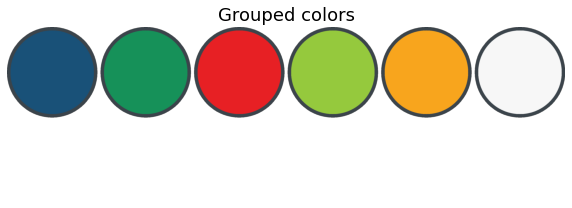

In [56]:
cluster_values_with_sorted_indexes = list(
    zip(cluster_values, range(len(cluster_values))))
cluster_values_with_sorted_indexes.sort(key=lambda x: x[0].mean(),
                                        reverse=False)

grouping_indexes = colors_grouping(
    [cl[0] for cl in cluster_values_with_sorted_indexes],
    65
)

grouping_indexes = [
    [cluster_values_with_sorted_indexes[v][1] for v in g]
    for g in grouping_indexes
]

grouped_colors = [
    cluster_values[get_class_index_from_groups(grouping_indexes, g[0])]
    for g in grouping_indexes
]

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Grouped colors', fontsize=18)
plt.imshow(draw_colors_horizontal_circles(grouped_colors))
plt.show()

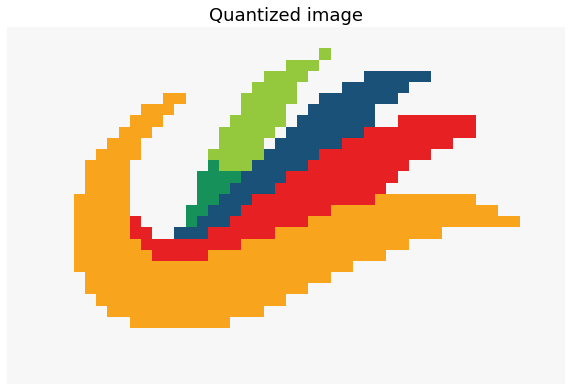

In [57]:
clusters_set = list(set(clustering.labels_))

quantized_resized_img = np.array([
    cluster_values[
        get_class_index_from_groups(
            grouping_indexes,
            clusters_set.index(clustering.labels_[i])
        )
    ]
    for i, p in enumerate(resized.reshape((-1, 3)))
]).reshape(resized.shape)

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Quantized image', fontsize=18)
plt.imshow(quantized_resized_img)
plt.show()

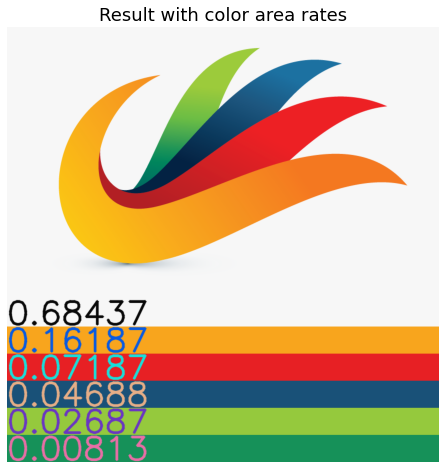

In [58]:
total_colors, cover_rates = np.unique(
    quantized_resized_img.reshape((-1, 3)),
    axis=0,
    return_counts=True
)

cover_rates = np.array([
    count / np.sum(cover_rates)
    for count in cover_rates
])

colors_with_rates = [
    (total_colors[i], cover_rates[i]) for i in range(len(cover_rates))
]
colors_with_rates = sorted(
    colors_with_rates,
    key=lambda x: x[1],
    reverse=True
)

total_colors = [tup[0] for tup in colors_with_rates]
cover_rates = [tup[1] for tup in colors_with_rates]

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Result with color area rates', fontsize=18)
plt.imshow(add_color_bar_to_image(img, total_colors, cover_rates))
plt.show()